In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import torch
from pathlib import Path
from hython.utils import write_to_zarr, build_mask_dataarray
import matplotlib.pyplot as plt
from pathlib import Path
from hython.datasets.datasets import get_dataset, CubeletsDataset
from numcodecs import Blosc

from torch.utils.data import Dataset, DataLoader

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from hython.trainer import HythonTrainer
from hython.trainer import train_val
from hython.sampler import SamplerBuilder, CubeletsDownsampler
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.convLSTM import ConvLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer
from hython.viz import show_cubelet_tile

from hython.sampler import compute_grid_indices
import itertools


import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


In [5]:
# PARAMETERS 

EXPERIMENT  = "q_land"

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/"

SURROGATE_MODEL_OUTPUT = f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/{EXPERIMENT}.pt"
TMP_STATS = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"

# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

# variables
dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'Swood','KsatVer', "Sl", "Kext", "f", "SoilThickness", "wflow_dem", "Slope", "c", "WaterFrac", "wflow_ldd"] # 'thetaS', 'thetaR', 'RootingDepth', 
target_names = [ "actevap", "vwc"] #, "runoff_land", "runoff_river", "snow", "snowwater"]#, "snow", "snowwater"]

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

DATASET = "CubeletsDataset" # "XBatchDataset"

XSIZE,YSIZE, TSIZE = 10, 10, 60
XOVER,YOVER,TOVER = 2, 2, 5

# == MODEL  ========================================================================================

HIDDEN_SIZE = 36
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
KERNEL_SIZE = (3, 3)
NUM_LSTM_LAYER = 2
OUTPUT_SIZE = len(target_names)

TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


# === SAMPLER/TRAINER ===================================================================================

# downsampling
DONWSAMPLING = True

TEMPORAL_FRAC = [0.3, 0.3] # train, test
SPATIAL_FRAC = [0.3, 0.3] 


SEED = 42
EPOCHS = 30
BATCH = 8


assert (sum(v for v in TARGET_WEIGHTS.values()) - 1) < 0.01, "check target weights"



In [6]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# === READ TRAIN ===================================================================
Xd = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd")
    .sel(time=train_temporal_range)[dynamic_names]
)
Xs = read_from_zarr(url=SURROGATE_INPUT , group="xs")[static_names]

Y = (
    read_from_zarr(url=SURROGATE_INPUT , group="y")
    .sel(time=train_temporal_range)[target_names]
)

SHAPE = Xd.attrs["shape"]

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="y")
    .sel(time=test_temporal_range)[target_names]
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd")
    .sel(time=test_temporal_range)[dynamic_names]
)

In [8]:
masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [27]:
if DONWSAMPLING:
   train_downsampler = CubeletsDownsampler(
        temporal_donwsample_fraction= TEMPORAL_FRAC[0], 
        spatial_downsample_fraction= SPATIAL_FRAC[0]
    )       
   test_downsampler = CubeletsDownsampler(
        temporal_donwsample_fraction= TEMPORAL_FRAC[-1], 
        spatial_downsample_fraction= SPATIAL_FRAC[-1]
    )
else:
    train_downsampler,test_downsampler = None, None

In [28]:
normalizer_dynamic = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False, save_stats=  f"{TMP_STATS}/{EXPERIMENT}_xd.nc")
normalizer_static = Normalizer(method = "standardize", type="space", axis_order = "xarray_dataset", dask_compute=False, save_stats=  f"{TMP_STATS}/{EXPERIMENT}_xs.nc")
normalizer_target = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False, save_stats=  f"{TMP_STATS}/{EXPERIMENT}_y.nc")

In [29]:
SHAPE = Xd.precip.shape
SHAPE

(1096, 180, 223)

In [30]:
train_dataset = get_dataset(DATASET)(Xd.chunk("auto"), 
                          Y.chunk("auto"),
                          Xs.chunk("auto"),
                          mask = masks,
                          downsampler=train_downsampler,
                          normalizer_dynamic = normalizer_dynamic, 
                          normalizer_static = normalizer_static,
                          normalizer_target = normalizer_target,
                          shape=SHAPE, # time, lat, lon
                          batch_size={"xsize":XSIZE,"ysize":YSIZE,"tsize":TSIZE}, 
                          overlap={"xover":XOVER, "yover":YOVER, "tover":TOVER},
                          missing_policy="any",
                          fill_missing=0,
                          persist=True, 
                          lstm_1d=False, 
                          static_to_dynamic=True
                         )

compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/q_land_xd.nc
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/q_land_xs.nc
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/q_land_y.nc


In [37]:
test_dataset = get_dataset(DATASET)(Xd_test.chunk("auto"), 
                          Y_test.chunk("auto"),
                          Xs.chunk("auto"),
                          mask = masks,
                          downsampler=test_downsampler,
                          normalizer_dynamic = normalizer_dynamic, 
                          normalizer_static = normalizer_static,
                          normalizer_target = normalizer_target,
                          shape=SHAPE, # time, lat, lon
                          batch_size={"xsize":XSIZE,"ysize":YSIZE,"tsize":TSIZE}, 
                          overlap={"xover":XOVER, "yover":YOVER, "tover":TOVER},
                          missing_policy="any",
                          fill_missing=0,
                          persist=True, 
                          lstm_1d=False, 
                          static_to_dynamic=True
                         )

In [38]:
len(train_dataset), len(test_dataset)

(240, 240)

In [39]:
# === SAMPLER ===================================================================


train_sampler_builder = SamplerBuilder(
    train_dataset,
    sampling="random", 
    processing="single-gpu")

test_sampler_builder = SamplerBuilder(
    test_dataset,
    sampling="sequential", 
    processing="single-gpu")


train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [40]:
# === DATA LOADER ================================================================

train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [41]:
#test_dataset.cbs_time_slices, test_dataset.cbs_time_idxs, test_dataset.cbs_mapping_idxs


In [43]:
for x,y,z in test_loader:
    print(x.shape,y.shape, z.shape)

torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10]) torch.Size([8, 60, 2, 10, 10])
torch.Size([8, 60, 3, 10, 10]) torch.Size([8, 60, 11, 10, 10

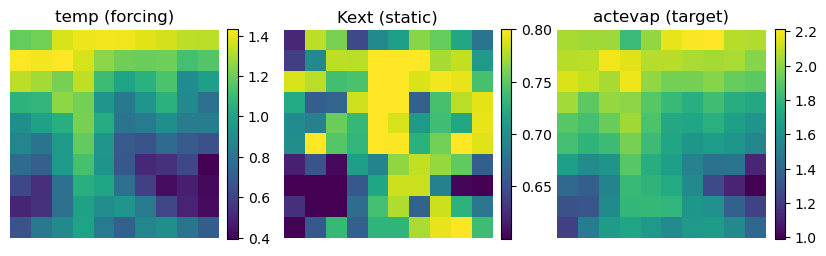

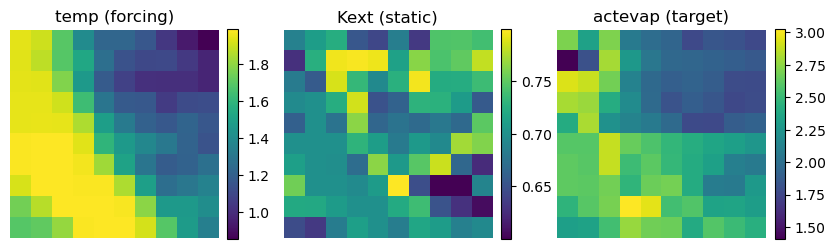

In [44]:
# === VIZ ========================================================================

show_cubelet_tile(train_dataset, 2, dynamic_var_idx=2, static_var_idx=3, static_names=static_names, 
                 target_names=target_names, dynamic_names=dynamic_names)

In [45]:
model = ConvLSTM(
    input_dim =  DYNAMIC_INPUT_SIZE + STATIC_INPUT_SIZE,
    output_dim= OUTPUT_SIZE,
    hidden_dim = (HIDDEN_SIZE),
    kernel_size = KERNEL_SIZE,
    num_layers = NUM_LSTM_LAYER,
    batch_first = True,
    bias = True,
    return_all_layers = False
).to(device)

In [46]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [47]:
trainer = HythonTrainer(
    RNNTrainParams(
               experiment=EXPERIMENT, 
               temporal_subsampling=False, 
               temporal_subset=1, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [48]:
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    SURROGATE_MODEL_OUTPUT,
    device
)


  0%|          | 0/30 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/q_land.pt
Copied best model weights!
train loss: 0.9325682520866394
val loss: 0.9227545261383057
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/q_land.pt
Copied best model weights!
train loss: 0.9260746836662292
val loss: 0.9178131818771362
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/q_land.pt
Copied best model weights!
train loss: 0.9270733594894409
val loss: 0.9169793725013733
train loss: 0.9331045150756836
val loss: 0.9235859513282776
train loss: 0.9274480938911438
val loss: 0.9240139722824097
train loss: 0.9266988635063171
val loss: 0.9259949922561646
train loss: 0.9272238612174988
val loss: 0.9237992167472839
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/q_land.pt
Copied best model weights!
train loss: 0.9134918451309204
val loss: 0.9136219620704651
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_dat

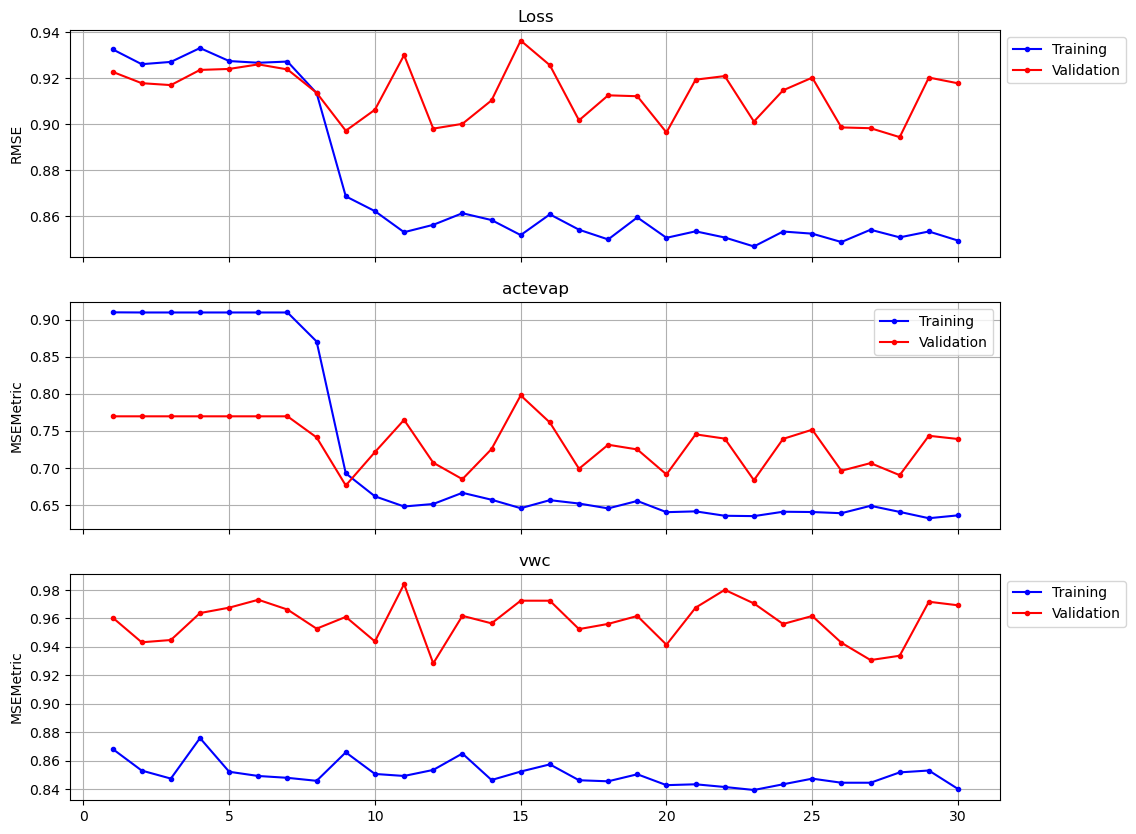

In [49]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('Loss')
axs[0].set_ylabel(loss_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

for i, variable in enumerate(target_names):
    axs[i+1].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i+1].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i+1].set_title(variable)
    axs[i+1].set_ylabel(metric_fn.__class__.__name__)
    axs[i+1].grid(True)
    axs[i+1].legend(bbox_to_anchor=(1,1))

In [69]:
def predict(Xd, Xs, model, batch_size, device):
    model = model.to(device)
    #if len(Xs[0]) > 1:
    X = torch.concat([Xd, Xs], 2).to(device)
    print(X.shape)
    #else:
    #    X = Xd.to(device)
    arr = []
    for i in range(0, Xd.shape[0], batch_size):
        out = model(X[i : (i + batch_size)])[0]
        #import pdb;pdb.set_trace()
        arr.append(out[i : (i + batch_size)].detach().cpu().numpy())
    return np.vstack(arr)

In [ ]:
res = next(iter(test_loader))
output = predict(res[0], res[1], model, batch_size=BATCH,device=device)

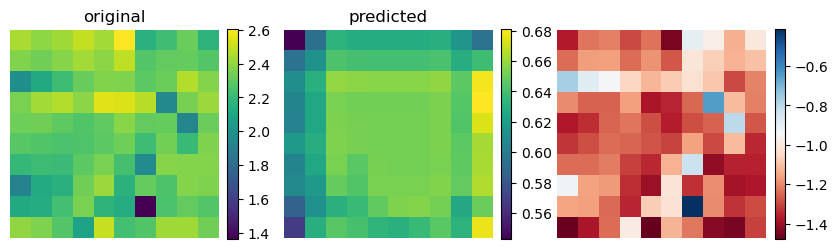

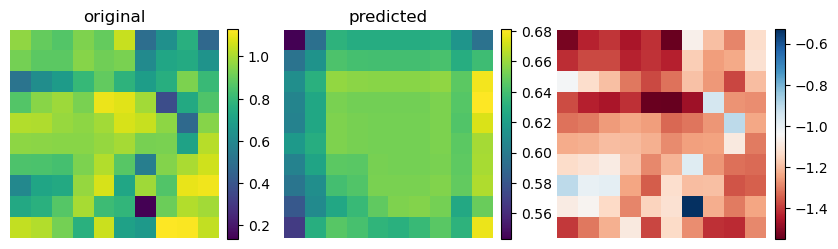

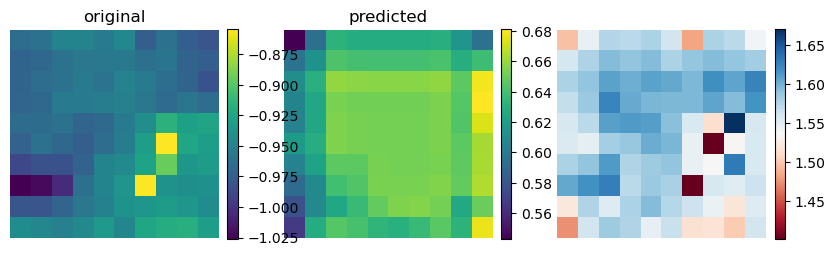

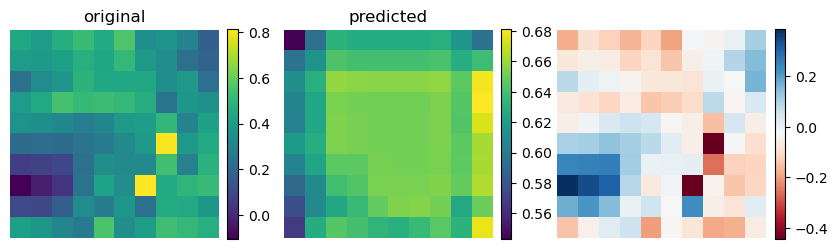

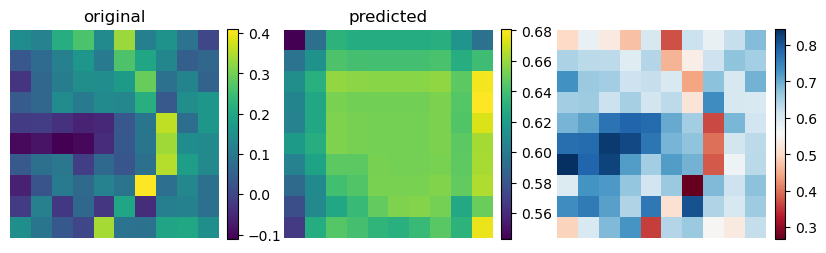

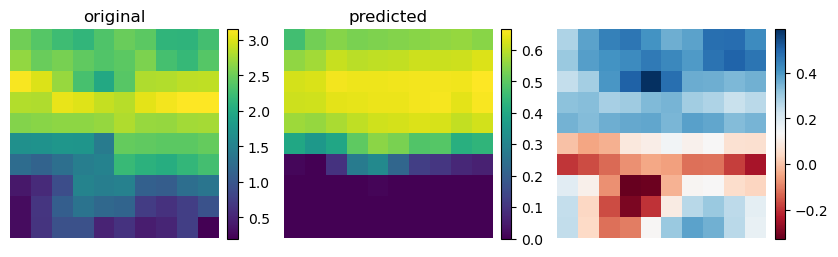

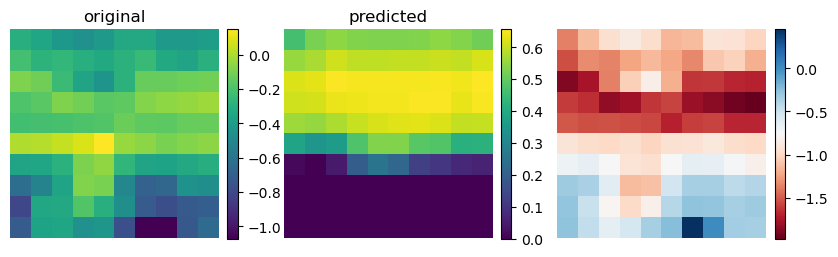

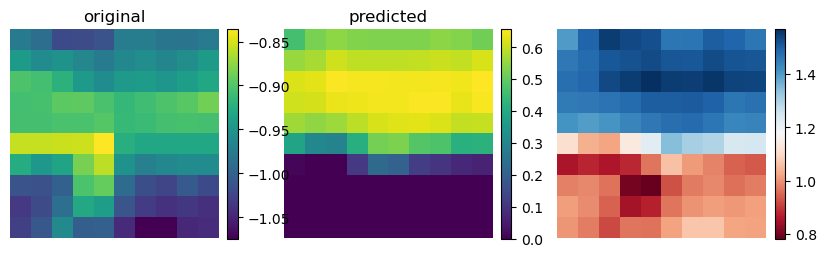

In [91]:
VARIABLE = 0
t = 50
# target
for i in range(output.shape[0]):
    fig, axs = plt.subplots(1,3, figsize = (10,4))
    
    p1 = axs[0].imshow(res[2][i,t, VARIABLE,:,:])
    axs[0].axis("off")
    plt.colorbar(p1,fraction=0.046, pad=0.04)
    axs[0].set_title("original")
    
    p2 = axs[1].imshow(output[i,t,:,:,VARIABLE])
    plt.colorbar(p2,fraction=0.046, pad=0.04)
    axs[1].set_title("predicted")
    axs[1].axis("off")
    
    p3 = axs[2].imshow((output[i,t,:,:,VARIABLE] - np.array(res[2][i,-1,VARIABLE,:,:])), cmap="RdBu")
    plt.colorbar(p3,fraction=0.046, pad=0.04)
    axs[2].axis("off")

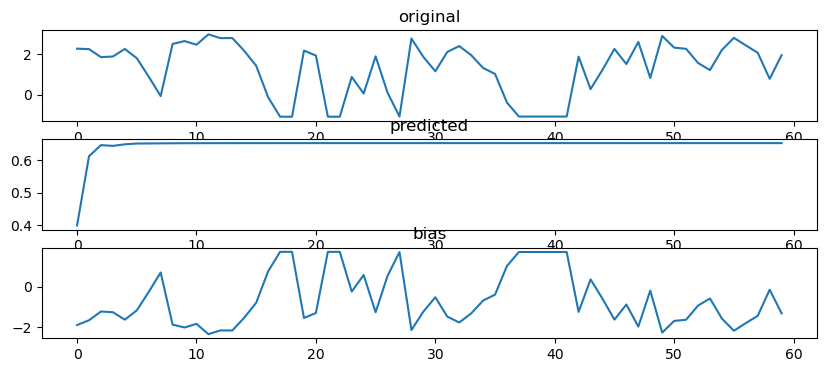

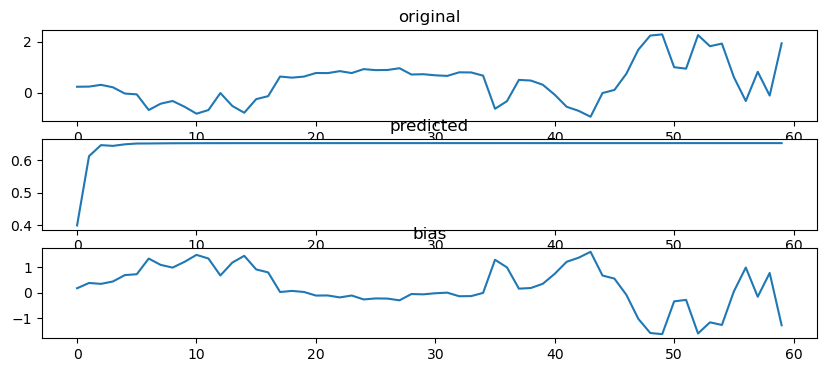

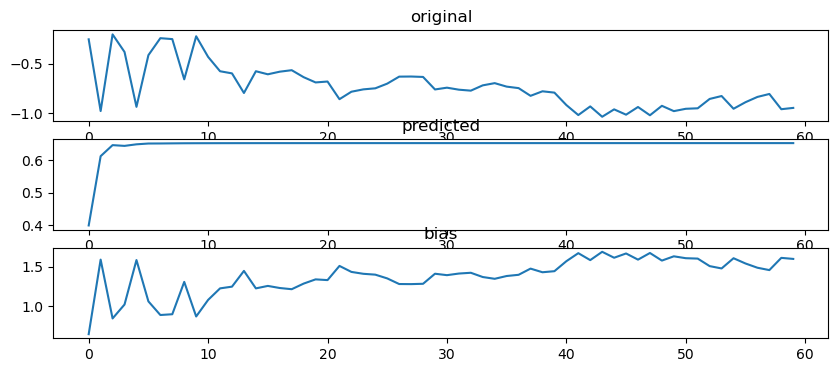

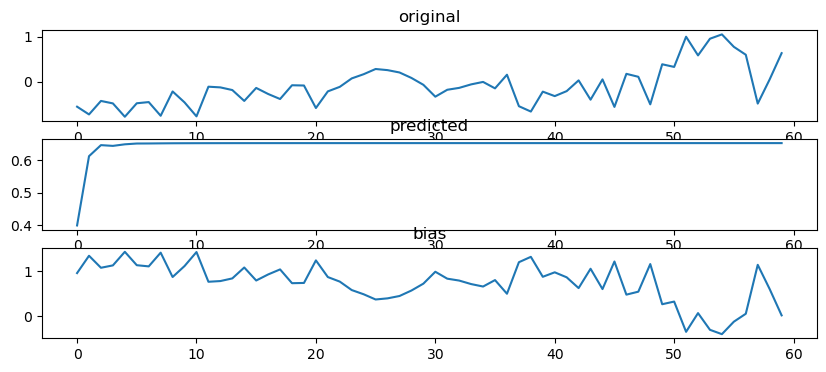

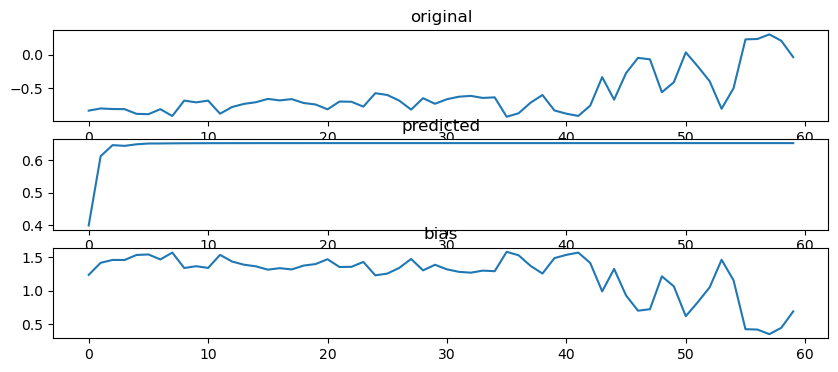

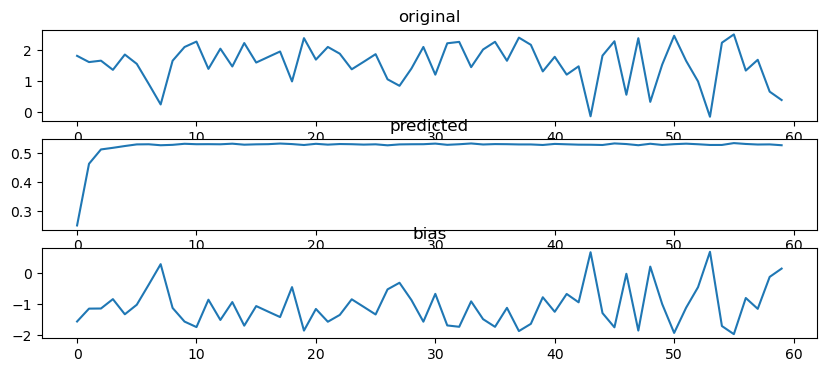

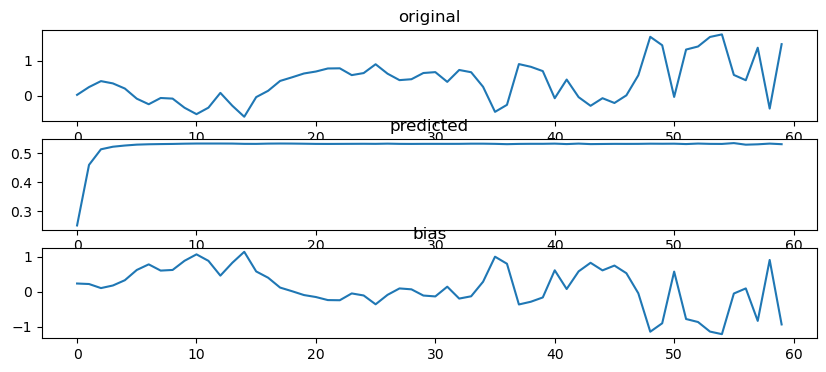

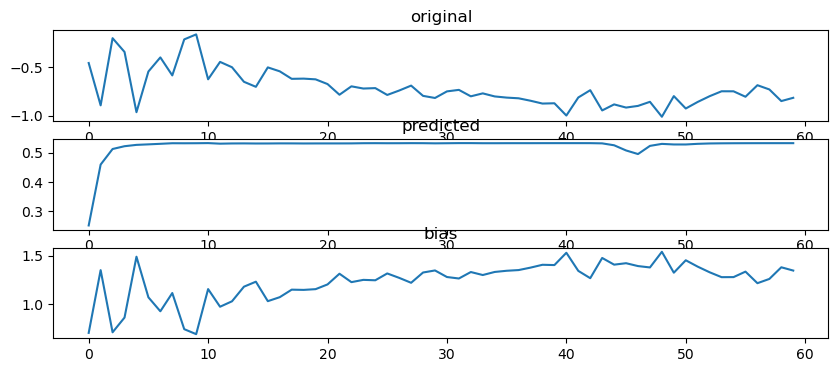

In [75]:
VARIABLE = 0
# target
for i in range(output.shape[0]):
    fig, axs = plt.subplots(3,1, figsize = (10,4))
    p1 = axs[0].plot(res[2][i,:,VARIABLE,5,5])
    #axs[0].axis("off")
    #plt.colorbar(p1,fraction=0.046, pad=0.04)
    axs[0].set_title("original")
    p2 = axs[1].plot(output[i,: ,5, 5,VARIABLE])
    #plt.colorbar(p2,fraction=0.046, pad=0.04)
    axs[1].set_title("predicted")
    #axs[1].axis("off")
    p3 = axs[2].plot((output[i,:,5,5,VARIABLE] - np.array(res[2][i,:,VARIABLE,5,5]))) #, cmap="RdBu")
    #plt.colorbar(p3,fraction=0.046, pad=0.04)
    #axs[2].axis("off")
    axs[2].set_title("bias")

# dev

In [97]:
# !! TODO: create a sampler that randomly select a different subset of temporal indices every epoch

# !! TODO: Add tests for xarray dataset normalizer

# TODO check very well case when static is None, what is returned by the dataset

# !!! TODO TRY WITH FAKE DATA FOR PARAMETER LEARNING

# !!! TODO for some reason predicted are constant no time varying

# TODO: Check against PredRNN